In [1]:
import sys
sys.path.append('..')

from spanemo.learner import Trainer, EvaluateOnTest
from spanemo.model import SpanEmo
from spanemo.data_loader import DataClass, twitter_preprocessor
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import datetime
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.metrics import roc_auc_score
import json

seed = 12345678
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if str(device) == 'cuda:0':
    print("Currently using GPU: {}".format(device))
else:
    print("WARNING: USING CPU")

Currently using GPU: cuda:0


In [3]:
preprocessor = twitter_preprocessor()

def make_loaders(args, test=False):
    if test:
        test_dataset = DataClass(args, args['test_path'], file_path=True, preprocessor=preprocessor)
        test_data_loader = DataLoader(test_dataset,
                                    batch_size=int(args['test_batch_size']),
                                    shuffle=False)
        print('The number of Test batches: ', len(test_data_loader))

        return test_data_loader
    else:
        train_dataset = DataClass(args, args['train_path'], file_path=True, preprocessor=preprocessor)
        train_data_loader = DataLoader(train_dataset,
                                    batch_size=int(args['train_batch_size']),
                                    shuffle=True
                                    )
        print('The number of training batches: ', len(train_data_loader))

        val_dataset = DataClass(args, args['val_path'], file_path=True, preprocessor=preprocessor)
        val_data_loader = DataLoader(val_dataset,
                                    batch_size=int(args['val_batch_size']),
                                    shuffle=False
                                    )
        print('The number of validation batches: ', len(val_data_loader))

        return train_data_loader, val_data_loader

Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...


/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter_2018 - 1grams ...


/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [4]:
def make_model(args):
    model = SpanEmo(output_dropout=args['output_dropout'],
                    backbone=args['backbone'],
                    joint_loss=args['loss_type'],
                    alpha=args['alpha_loss'])
    
    return model


In [5]:
def pipeline(args, loaders=None):
    now = datetime.datetime.now()
    filename = now.strftime("%Y-%m-%d-%H:%M:%S")
    fw = open('configs/' + filename + '.json', 'a')
    json.dump(args, fw, sort_keys=True, indent=2)

    if loaders is None:
        train_data_loader, val_data_loader = make_loaders(args)
    else:
        train_data_loader, val_data_loader = loaders
    model = make_model(args)

    learn = Trainer(model, train_data_loader, val_data_loader, filename=filename)
    learn.fit(
        num_epochs=int(args['max_epoch']),
        args=args,
        device=device
    )

In [6]:
hyperparams = {
    'train_path':'data/train.csv', 
    'val_path':'data/val.csv',
    'backbone':'bert-large-uncased',
    'train_batch_size': 64,
    'val_batch_size': 64,
    'output_dropout': 0.1,
    'loss_type': 'joint',
    'alpha_loss': 0.2,
    'max_epoch': 20,
    'max_length': 128,
    'ffn_lr': 0.001,
    'bert_lr': 2e-5
}

In [7]:
# tuning = {
#     'train_batch_size': [64, 128, 256],
#     'output_dropout': [0.05, 0.1, 0.15],
#     'loss_type': ['joint', 'cross-entropy', 'corr_loss'],
#     'ffn_lr': 0.001,
#     'bert_lr': 2e-5

# }

In [8]:
assert False

AssertionError: 

## Train

In [ ]:
loaders = make_loaders(hyperparams)

100%|██████████| 6838/6838 [00:03<00:00, 1797.65it/s]


The number of training batches:  107


100%|██████████| 886/886 [00:00<00:00, 1361.68it/s]

The number of validation batches:  14


In [ ]:
#wooooooooooooooooooooo
pipeline(hyperparams, loaders=loaders)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/alexlu/miniconda3/envs/emo/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future ver

Train_Loss,Val_Loss,F1-Macro,F1-Micro,JS,Time
0.5189,0.3831,0.4572,0.6620,0.5395,01:34
0.3772,0.3620,0.5851,0.7142,0.5964,01:35
0.3371,0.3542,0.5759,0.7155,0.6019,01:35
0.3026,0.3580,0.5730,0.7225,0.6135,01:35
0.2724,0.3807,0.6009,0.7224,0.6026,01:35
0.2460,0.3990,0.5818,0.7078,0.5915,01:29
0.2198,0.4130,0.5850,0.7183,0.6059,01:27


epoch#:  1
Validation loss decreased (inf --> 0.383081).  Saving model ...
epoch#:  2
Validation loss decreased (0.383081 --> 0.362023).  Saving model ...
epoch#:  3
Validation loss decreased (0.362023 --> 0.354167).  Saving model ...
epoch#:  4
EarlyStopping counter: 1 out of 5
epoch#:  5
EarlyStopping counter: 2 out of 5
epoch#:  6
EarlyStopping counter: 3 out of 5
epoch#:  7
EarlyStopping counter: 4 out of 5
epoch#:  8
EarlyStopping counter: 5 out of 5
Early stopping


## Test

In [9]:
def test(args, model_path, loader=None):

    if loader is None:
        test_data_loader = make_loaders(args, test=True)
    else:
        test_data_loader = loader

    model = make_model(args)
    
    learn = EvaluateOnTest(model, test_data_loader, model_path='models/' + model_path)
    return learn.predict(device=device)

In [10]:
hyperparams['test_path'] = 'data/test.csv'
hyperparams['test_batch_size'] = 64

In [11]:
test_loader = make_loaders(hyperparams, test=True)

100%|██████████| 3259/3259 [00:02<00:00, 1535.05it/s]

The number of Test batches:  51


In [12]:
preds = test(hyperparams, "final_model.pt", loader=test_loader)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


F1-Macro: 0.5859 F1-Micro: 0.7174 JS: 0.5999 Time: 00:15


In [24]:
label_names = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "hopeless", "sadness", "surprise", "trust"]

abc = np.concatenate((preds["y_true"], preds["y_pred"], preds["logits"]), axis=1)
d = pd.DataFrame(abc, columns=[name+suffix for suffix in ["_True", "_Pred", "_Logits"] for name in label_names])

In [25]:
d.to_csv("abc.csv")

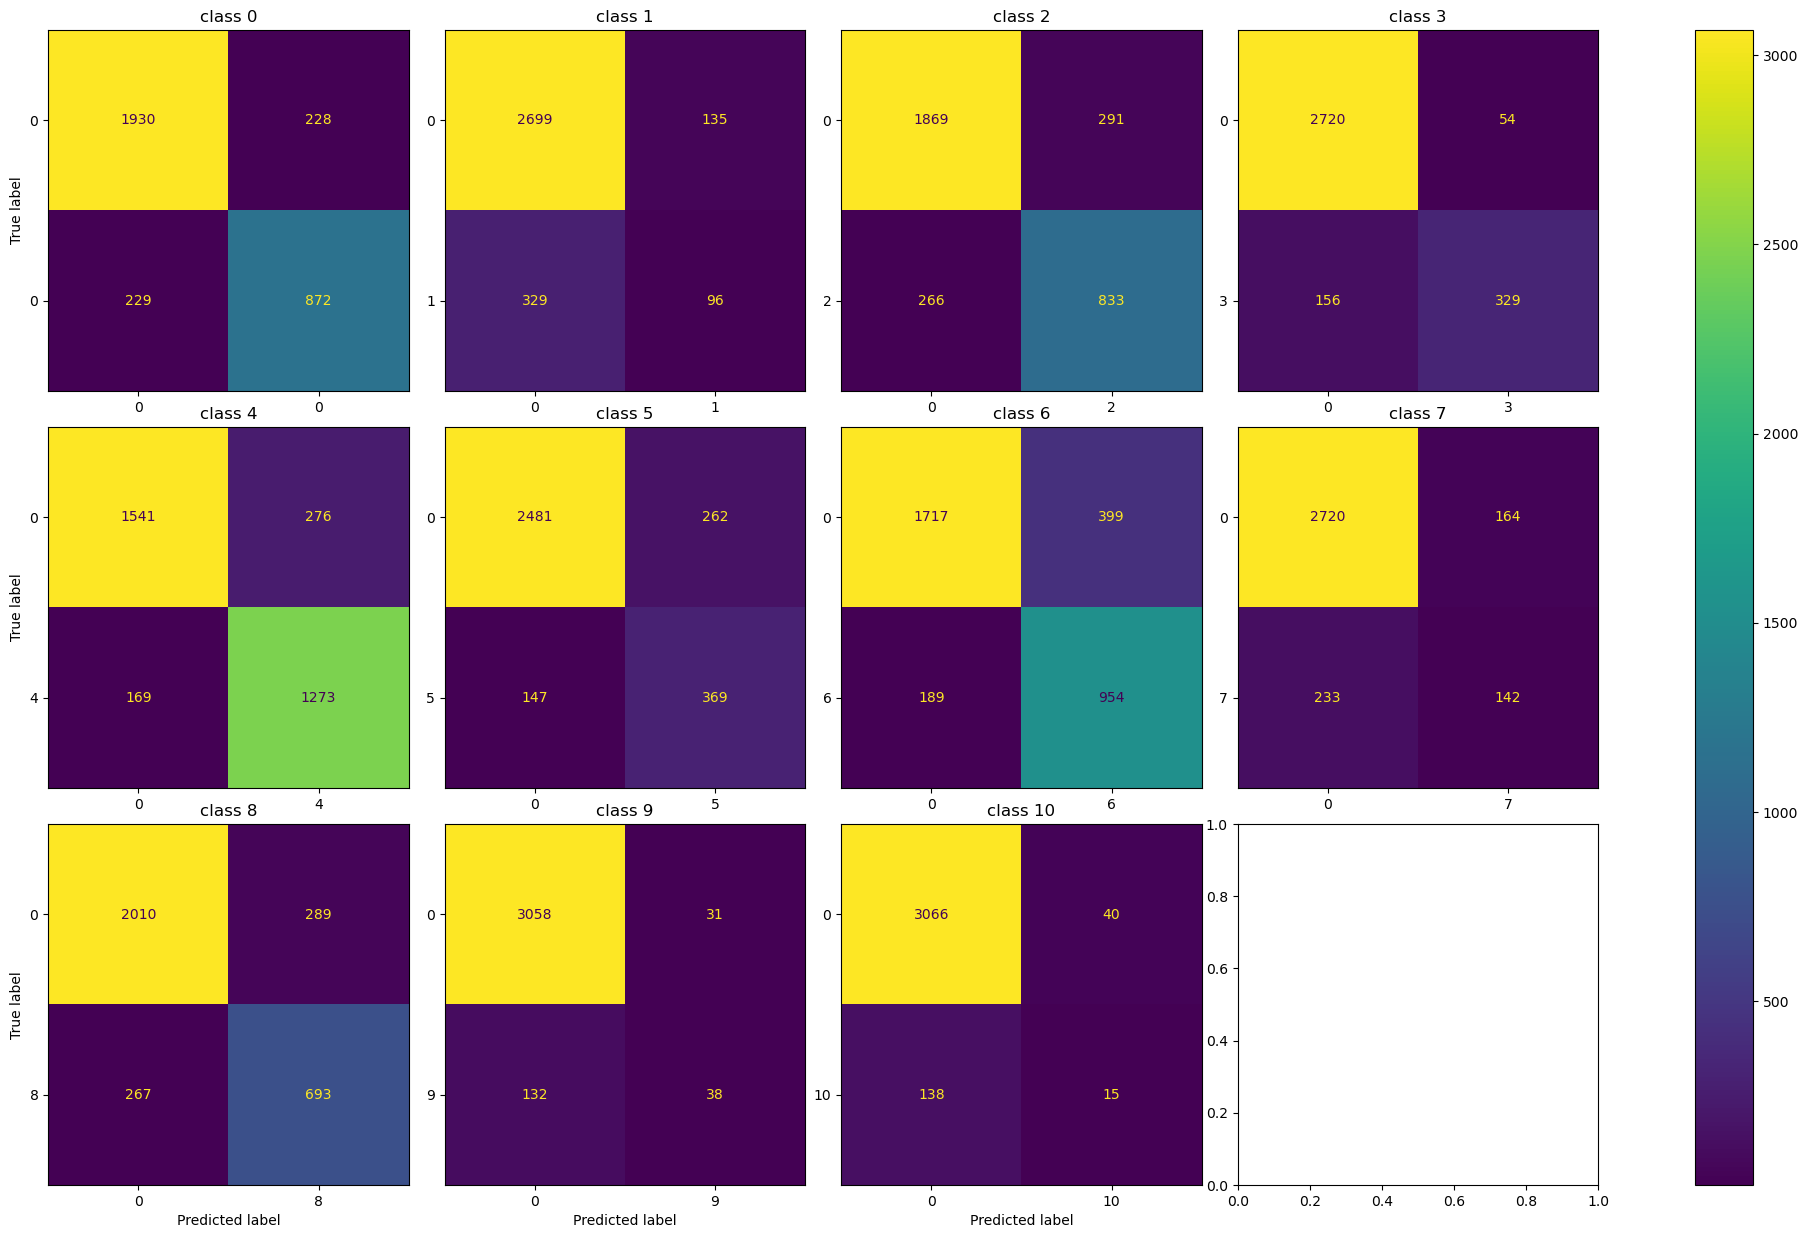

In [31]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
multilabel_confusion_matrix(preds["y_true"], preds["y_pred"])

f, axes = plt.subplots(3, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(11):
    disp = ConfusionMatrixDisplay(confusion_matrix(preds["y_true"][:, i],
                                                   preds["y_pred"][:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i<8:
        disp.ax_.set_xlabel('')
    if i%4!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()


In [13]:
print("Macro AUC:", roc_auc_score(preds["y_true"], preds["logits"], average="macro"))
print("Micro AUC:", roc_auc_score(preds["y_true"], preds["logits"], average="micro"))

Macro AUC: 0.8728746252681101
Micro AUC: 0.9139985980218792


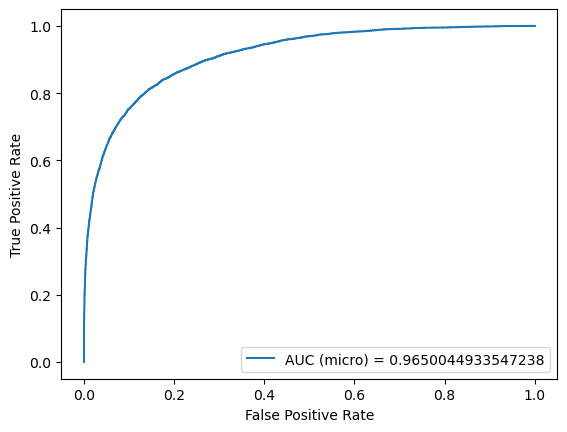

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(preds["y_true"].flatten(), preds["logits"].flatten())

plt.plot(fpr, tpr, label="AUC (micro) = 0.9650044933547238")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc=4)

In [ ]:
from sklearn.metrics import f1_score, jaccard_score

In [ ]:
model = make_model(hyperparams)
model.load_state_dict(torch.load("models/final_model.pt"))
model.to(device)
_ = model.eval()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
dc = DataClass(hyperparams, ["i can't wait"], pred_mode=True)
dl = DataLoader(dc, batch_size=100, shuffle=False)

Reading twitter_2018 - 1grams ...
Reading twitter_2018 - 2grams ...
Reading twitter_2018 - 1grams ...


100%|██████████| 1/1 [00:00<00:00, 1820.44it/s]


In [ ]:
logits = model.predict(next(iter(dl)), device)[2].cpu().detach().numpy()
probs = 1/(1+np.exp(-logits))[0]

# label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]
label_names = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "hopeless", "sadness", "surprise", "trust"]

for i in range(len(label_names)):
    print(f"{probs[i]:.3f}", label_names[i])

0.010 anger
0.699 anticipation
0.008 disgust
0.143 fear
0.505 joy
0.005 love
0.020 optimism
0.013 hopeless
0.067 sadness
0.014 surprise
0.001 trust


In [14]:
# label_names = ["admiration", "amusement", "anger", "annoyance", "approval", "caring", "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", "nervous", "optimism", "pride", "realization", "relief", "remorse", "sadness", "surprise", "neutral"]
label_names = ["anger", "anticipation", "disgust", "fear", "joy", "love", "optimism", "hopeless", "sadness", "surprise", "trust"]

y_true = pd.DataFrame(preds['y_true'], columns=label_names)
y_pred = pd.DataFrame(preds['y_pred'], columns=label_names)
logits = pd.DataFrame(preds['logits'], columns=label_names)

correlation = "pearson"

y_true_corr = y_true.corr(correlation)
y_pred_corr = y_pred.corr(correlation)
logits_corr = logits.corr(correlation)

In [16]:
logits_corr.to_csv("corr.csv")

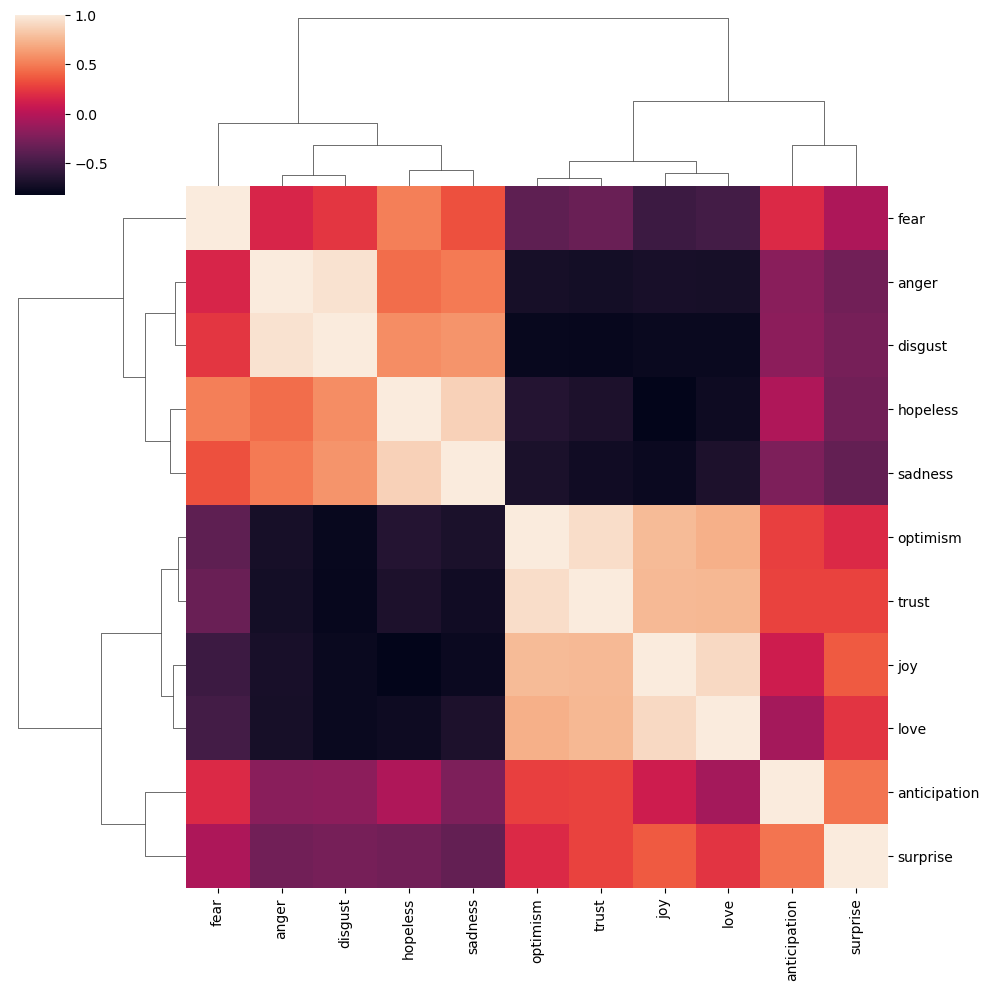

In [ ]:
_ = sns.clustermap(logits_corr, annot=False)

In [ ]:
# data = pd.read_csv("data/test.csv")

# wrongs = [(i[0], i[1].sum(), [(j, label_names[j]) for j, x in enumerate(i[1]) if x]) for i in enumerate(preds['y_true'] != preds['y_pred']) if i[1].any()]
# test_data = [(i, data['text'][i], [(j, label_names[j]) for j in range(28) if data[str(j)][i]]) for i in data.index]
# test_data = [test_data[i[0]] for i in wrongs]